# **Welcome To the Notebook**


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [ ]:
!pip install pyspark

26/02/06 05:48:24 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Importing Modules

In [1]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [2]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [35]:
df = spark.read.format('csv').option('inferSchema', True).option('header', True).load('dataset.csv')
df.show(5, truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|7590-VHVEG|Female|No           |Yes    |No        |1     |No          |No phone service|DSL            |No            |Yes         |No              |N

Print the data schema to check out the data types

In [ ]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [ ]:
df.count() # number of rows

7043

In [ ]:
len(df.columns) # number of columns

21

### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [ ]:
df.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

Let's get all the numerical features and store them into a pandas dataframe.

In [36]:
num_cols = [name for name, typ in df.dtypes if typ == "double" or typ == "int"]
cat_cols = [name for name, typ in df.dtypes if typ == "string"]
cat_cols

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [ ]:
# show num_cols in our data
df.select(num_cols).show(5)

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
+------+--------------+------------+
only showing top 5 rows


In [ ]:
df1 = df.select(num_cols).toPandas()
df1.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns.

### <code>Histogram</code> are useful in identifying outliers in numerical columns. The distibution of values help us identify unusual values and patterns that require investigation.

/tmp/ipython-input-3419165439.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df1.hist(ax=ax, bins=20)


,tenure
count,7043.000000
mean,32.435752
std,25.075228
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,458.000000


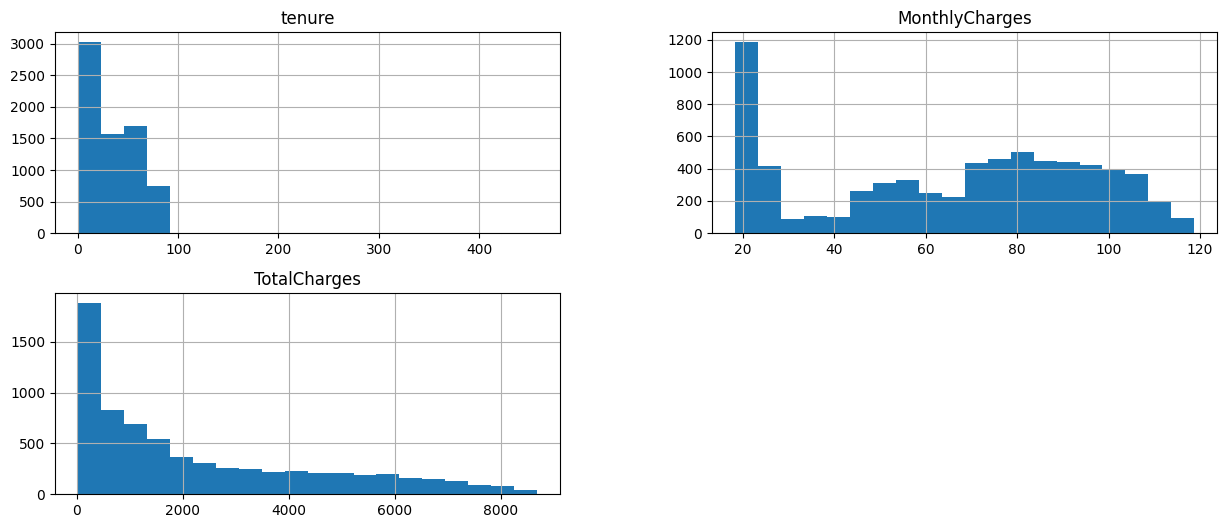

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca()
df1.hist(ax=ax, bins=20)
df1.tenure.describe()

#### We noticed in the histogram for <code>tenure</code> is so stretched. Why is that? There should be some values between 100 and 499. To investigate this, we can extract descriptive stats for tenure column using <code>describe</code> function.

#### Viewing descriptive stats for tenure column shows that the tenure has a mean value of 32 and maximum value of 458, that means we have an outlier.

Let's generate the correlation matrix

In [ ]:
df1.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


### We can see a strong correlation between <code>tenure</code> and <code>TotalCharges</code>. As tenure increases, the total charges will be increase.

Let's check the unique value count per each categorical variables

In [ ]:
df.groupby("Contract").count().show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



In [ ]:
for column in cat_cols:
  df.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows
+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682|

### Insights from unqiue values:
- From senior citizen (yes/no) we can see that most of our customers are not senior citizen.

- For phone service, we can see that very small proportion customers are not using the phone services and most of them are.

- For Internet service, most of our customers are using fiber optic.

- For Onlne Security, Online Backup and Device Protection, most of the customers does not have one.

- Churn (our target column) is imbalanced as well, further investigation needs to be conducted.



Let's find number of null values in all of our dataframe columns

In [ ]:
df.filter(col('Churn').isNull()).count()

0

In [5]:
df.select(count(when(col('Churn').isNull(), "Churn")).alias('Churn')).show()

+-----+
|Churn|
+-----+
|    0|
+-----+



In [ ]:
for column in df.columns:
  df.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

In <code>TotalCharges</code>, we have 11 null values.

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [37]:
cols_with_null = "TotalCharges"

Creating our Imputer

In [38]:
imputer = Imputer(inputCol=cols_with_null, outputCol=cols_with_null).setStrategy("mean")

Use Imputer to fill the missing values

In [39]:
imputer = imputer.fit(df)
df = imputer.transform(df)

Let's check the missing value counts again

In [40]:
df.filter(col('TotalCharges').isNull()).count()

0

In [41]:
df.select(count(when(col('TotalCharges').isNull(), "Total_Charges")).alias("Total_Charges")).show()

+-------------+
|Total_Charges|
+-------------+
|            0|
+-------------+



**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [42]:
df.select("*").where(df.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [43]:
df = df.filter(df.tenure < 100)
print('After removing the outliers', df.count())

After removing the outliers 7042


### **Task 4 - Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [44]:
num_assembler = VectorAssembler(inputCols=num_cols, outputCol='num_features_vector')
df = num_assembler.transform(df)
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| num_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [45]:
scaler = StandardScaler(inputCol = "num_features_vector", outputCol="num_features_scaled", withStd=True, withMean=True)
df = scaler.fit(df).transform(df)

In [ ]:
df.show(5, truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+-------------------+---------------------------------------------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|num_features_vector|num_features_scaled                                            |
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+---

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [46]:
cat_cols_indexed = [name + "_Indexed" for name in cat_cols]
indexer = StringIndexer(inputCols = cat_cols, outputCols=cat_cols_indexed)
df = indexer.fit(df).transform(df)
df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|num_features_vector| num_features_s

Let's combine all of our categorifal features in to one feature vector.

In [47]:
from numpy import vectorize
cat_cols_indexed.remove('customerID_Indexed')
cat_cols_indexed.remove('Churn_Indexed')

cat_assembler = VectorAssembler(inputCols=cat_cols_indexed, outputCol="cat_features_vector")
df = cat_assembler.transform(df)
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBillin

Now let's combine categorical and numerical feature vectors.

In [48]:
final_assembler = VectorAssembler(inputCols=["cat_features_vector", "num_features_scaled"], outputCol="final_vector")
df = final_assembler.transform(df)
df.select(["final_vector", "Churn_indexed"]).show(5)

+--------------------+-------------+
|        final_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
+--------------------+-------------+
only showing top 5 rows


### **Task 5 - Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model

In this task, we are going to start training our model

In [49]:
train, test = df.randomSplit([0.7, 0.3], seed=100)

train.count()

4930

Now let's create and train our desicion tree

In [ ]:
train.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Con

In [50]:
dt = DecisionTreeClassifier(featuresCol="final_vector", labelCol="Churn_Indexed", maxDepth=6)
model = dt.fit(train)

Let's make predictions on our test data

In [51]:
pred = model.transform(test)
pred.select(['Churn', 'prediction']).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows


In [23]:
pred.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+--------------------+-------------+--------------------+----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling| 

### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [52]:
evalutor = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
auc_test = evalutor.evaluate(pred, {evalutor.metricName: "areaUnderROC"})
auc_test

0.7968240892739675

Let's get the AUC for our `training` set

In [53]:
pred_train = model.transform(train)
auc_train = evalutor.evaluate(pred_train, {evalutor.metricName: "areaUnderROC"})
auc_train

0.797607974377661

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [54]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [58]:
maxDepth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

test_accs, train_accs = evaluate_dt(maxDepth)
print(train_accs)
print(test_accs)

[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.797607974377661, 0.7600331160893413, 0.7616399322585649, 0.7851198149534798, 0.82591977092655, 0.8633625692715379, 0.8899907318309699, 0.9236516335825413, 0.9402616892332477, 0.9521037242780167, 0.9662424766482165, 0.9763120733848871, 0.9807472862567603, 0.9853808496196841, 0.9883361989750398]
[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968240892739675, 0.7464077658395512, 0.7486976928866473, 0.7390283218461648, 0.7568262227463716, 0.7717528253693575, 0.770466222983424, 0.7493673661690539, 0.7371905724224987, 0.7208594338001293, 0.7102797812005524, 0.704298946894316, 0.7036452746549405, 0.6956814962753128, 0.6895714683623821]


Let's visualize our results

In [59]:
df = pd.DataFrame()
df["maxDepth"] = maxDepth
df["trainAcc"] = train_accs
df["testAcc"] = test_accs

df.head()

px.line(df, x="maxDepth", y=["trainAcc", "testAcc"])


### Insights from the Line Plot

 - As the maxDepth is increasing, train_acc is increasing as well until it reaches at 98%, when the max depth is 20. This is when the model is so perfect for the training set that it is unable to capture any patterns from test set, which is overfitting.

- When max depth is 5, both train and test accuracies is really low, this is called underfitting. When we can see at depth 6, when train and test accuracies is 0.797608 at their highest point. After that point, the model starts to get overfitted.

- So, optimal max depth for decision tree model is going to be six.

### **7 - Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn.


Use feature importance to identify the most important feature in our model, this will help us understand which feature has the greatest impact on predicting customer churn.

In [56]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df1 = pd.DataFrame(scores, columns = ['scores'], index= cat_cols_indexed + num_cols)
px.bar(df1, y='scores')

Let's create a bar chart to visualize the customer churn per contract type

In [57]:
df3 = df.groupby("Contract", "Churn").count().toPandas()
px.bar(df3, x="Contract", y="count", color="Churn")

### Insights from bar chart

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.